In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

In [ ]:
aggXGB = pd.read_parquet("Data/agg_table_new_zones8Bot.parquet")
pivot_df = aggXGB.pivot(index='time_bin', columns='h3_index', values='order_count').fillna(0) #we need H3 indeces to map with ABM

In [3]:
original_area_columns = pivot_df.columns.tolist()

In [4]:
#Preparing features
pivot_df = pivot_df.reset_index()
pivot_df['hour'] = pivot_df['time_bin'].dt.hour
pivot_df['dayofweek'] = pivot_df['time_bin'].dt.dayofweek
pivot_df['hour_sin'] = np.sin(2 * np.pi * pivot_df['hour'] / 24) #sin and cos better as cyclian feature
pivot_df['hour_cos'] = np.cos(2 * np.pi * pivot_df['hour'] / 24)
pivot_df['day_sin'] = np.sin(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['day_cos'] = np.cos(2 * np.pi * pivot_df['dayofweek'] / 7)
pivot_df['is_weekend'] = pivot_df['dayofweek'].isin([5, 6]).astype(int)
time_bins_original = pivot_df['time_bin'].copy()


In [5]:
pivot_df_for_model = pivot_df.drop(columns=['time_bin', 'hour', 'dayofweek']) #don't need anymore as feature

In [6]:
# List of feature columns
feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'is_weekend']

# we drop feature columns to achieve only area df
area_columns = pivot_df_for_model.columns.drop(feature_cols).tolist()
n_areas = len(area_columns) #amount of hexagons

data = pivot_df_for_model[area_columns + feature_cols].values

In [7]:
def create_xgb_dataset(data, time_steps=4, n_features=None): #we go 4 steps back
    X, y = [], []
    for i in range(len(data) - time_steps):
        features_part = data[i:i+time_steps, :n_features].flatten()
        cyc_features = data[i+time_steps, n_features:]
        X.append(np.concatenate([features_part, cyc_features]))
        y.append(data[i+time_steps, :n_features])
    return np.array(X), np.array(y)

In [ ]:
time_steps = 4
X, y = create_xgb_dataset(data, time_steps=time_steps, n_features=n_areas) 

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.125, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, shuffle=False
)

In [12]:
models = []
predictions = np.zeros_like(y_test)

In [ ]:
for i in range(y.shape[1]):  #for every target variable
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        verbosity=0,
        random_state=42,
        early_stopping_rounds=50
    )
    #use only default values
    
    model.fit(
        X_train, y_train[:, i],
        eval_set=[(X_val, y_val[:, i])],
        verbose=False 
    )
    pred = model.predict(X_test)
    predictions[:, i] = pred
    models.append(model)
print("Training abgeschlossen.")

Training abgeschlossen.


In [14]:
# connect everything for evaluation
y_tests_all = np.concatenate(y_test)
y_preds_all = np.concatenate(predictions)

In [15]:
n = len(y_tests_all)
p = X.shape[1]

#all basic evaluations 

rmse = np.sqrt(mean_squared_error(y_tests_all, y_preds_all)) 
mae = mean_absolute_error(y_tests_all, y_preds_all)
r2 = r2_score(y_tests_all, y_preds_all)
nrmse = rmse / np.mean(np.abs(y_tests_all)) * 100
nonzero_indices = y_tests_all != 0
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)


if np.any(nonzero_indices):
    mape = np.mean(np.abs((y_tests_all[nonzero_indices] - y_preds_all[nonzero_indices]) / y_tests_all[nonzero_indices])) * 100
else:
    mape = np.nan

print("Evaluation über alle Areas hinweg:")
print(f"MAPE: {mape:.2f}%")
print(f"NRMSE: {nrmse:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
print(f"Adjusted R²: {adj_r2:.2f}")

Evaluation über alle Areas hinweg:
MAPE: 47.43%
NRMSE: 59.46%
RMSE: 2.74
MAE: 1.31
R²: 0.94
Adjusted R²: 0.94


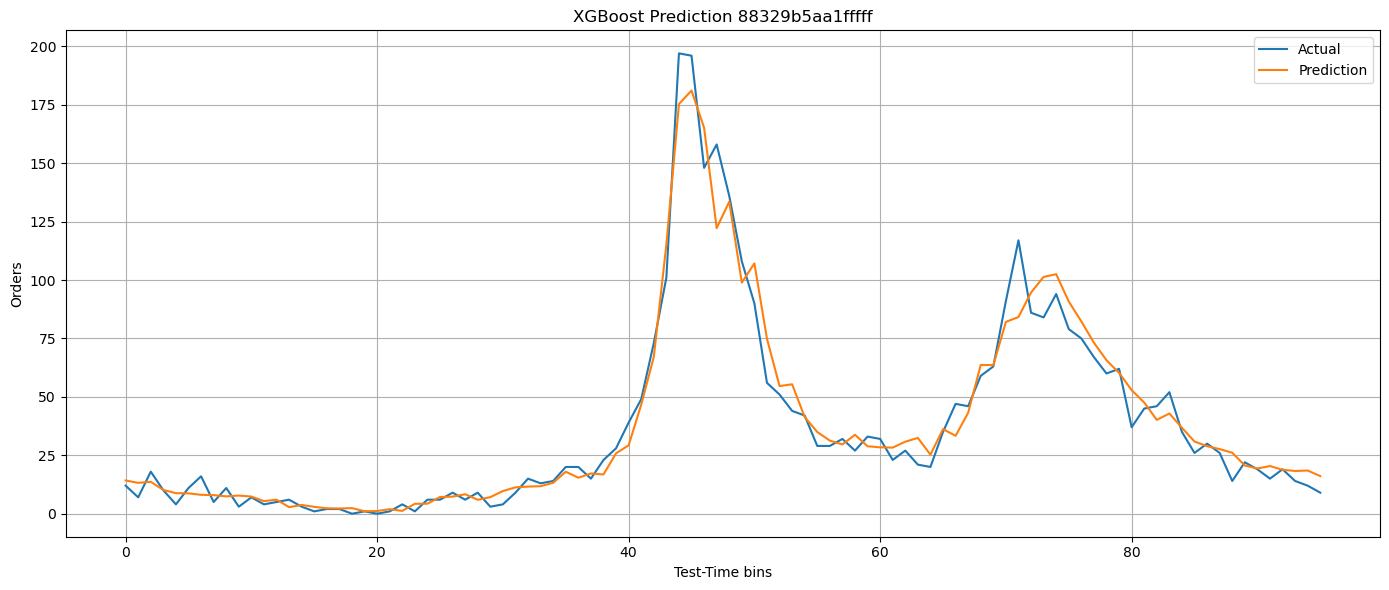

In [16]:
example_area = "88329b5aa1fffff"  # change the area to observe
example_index = original_area_columns.index(example_area)

plt.figure(figsize=(14, 6))
plt.plot(y_test[:, example_index], label='Actual')
plt.plot(predictions[:, example_index], label='Prediction')
plt.title(f'XGBoost Prediction {example_area}')
plt.xlabel('Test-Time bins')
plt.ylabel('Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
example_area = "88329b5aa1fffff"  # change the area to observe
example_index = original_area_columns.index(example_area)
np.save('prognose_XGB.npy', predictions[:, example_index])


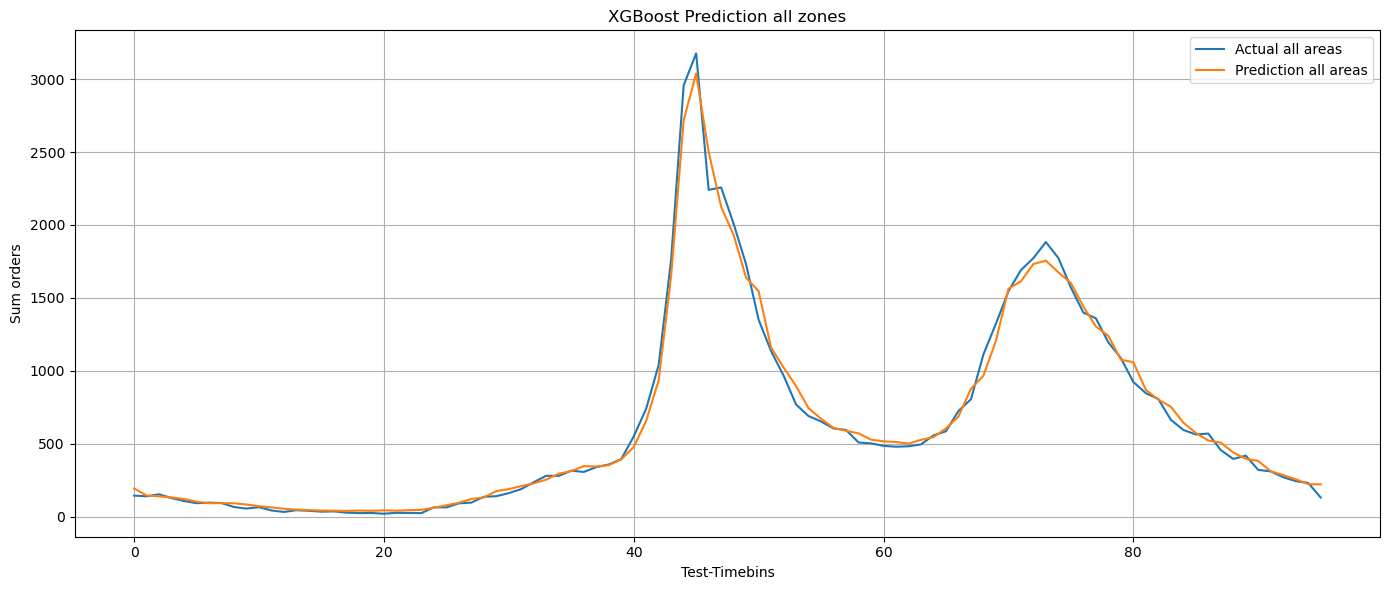

In [ ]:
# Plot for everything
total_actual = np.sum(y_test, axis=1)
total_predicted = np.sum(predictions, axis=1)

plt.figure(figsize=(14, 6))
plt.plot(total_actual, label='Actual all areas')
plt.plot(total_predicted, label='Prediction all areas')
plt.title('XGBoost Prediction all zones')
plt.xlabel('Test-Timebins')
plt.ylabel('Sum orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#sum the orders for evaluation
total_actual = np.sum(y_test, axis=1)
total_predicted = np.sum(predictions, axis=1)

rmse_total = np.sqrt(mean_squared_error(total_actual, total_predicted))
mae_total = mean_absolute_error(total_actual, total_predicted)
r2_total = r2_score(total_actual, total_predicted)
mask = total_actual != 0

if np.any(mask):
    mape_total = np.mean(np.abs((total_actual[mask] - total_predicted[mask]) / total_actual[mask])) * 100
else:
    mape_total = np.nan

print(f"--- Metrics for orders ---")
print(f"RMSE (Total): {rmse_total:.2f}")
print(f"MAE  (Total): {mae_total:.2f}")
print(f"R²   (Total): {r2_total:.2f}")
print(f"MAPE (Total): {mape_total:.2f}%")


--- Metrics for orders ---
RMSE (Total): 66.69
MAE  (Total): 43.68
R²   (Total): 0.99
MAPE (Total): 14.48%


In [ ]:
"""
Here we prepare the output for our ABM
"""

test_timestamps = time_bins_original.iloc[split_idx + time_steps:].reset_index(drop=True)
predictions_df_wide = pd.DataFrame(predictions, columns=area_columns)
predictions_df_wide['time_bin'] = test_timestamps

#Bring data frame into format
predictions_df_long = pd.melt(
    predictions_df_wide,
    id_vars=['time_bin'],
    var_name='hex_id',
    value_name='predicted_order_count'
)
predictions_df_long['predicted_order_count'] = predictions_df_long['predicted_order_count'].round().astype(int)
predictions_df_long['predicted_order_count'] = predictions_df_long['predicted_order_count'].clip(lower=0)
predictions_df_long['time_bin'] = pd.to_datetime(predictions_df_long['time_bin'])

#Define the times
start_time = '2022-10-24 14:00:00'
end_time = '2022-10-24 17:00:00'

filtered_predictions_df = predictions_df_long[
    (predictions_df_long['time_bin'] >= start_time) &
    (predictions_df_long['time_bin'] <= end_time)
].copy() # .copy() to have a clean copy


output_path_filtered = "Data/predicted_values.parquet"
